In [1]:
import os
import sys
from time import time

import numpy as np

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import plot_matches

from matplotlib import pyplot as plt

import pyoneacpose

# rootdir should be the root of the cloned repository
rootdir=os.getcwd()

# import MegaDepth (requires pytorch!)
sys.path.insert(1, rootdir + '/third_party/MegaDepth')
from third_party.MegaDepth import predict_depth

## Input: images and intrisic matrices

In [2]:
# test image pair from the Piccadilly scene from the 1DSfM dataset
img_left_path  = rootdir + '/data/piccadilly/1081610695_de3f8ed360_o.jpg'
img_right_path = rootdir + '/data/piccadilly/1086847257_1cbe805abb_o.jpg'
K_l = np.array([[832.657, 0.0, 284.0],[0.0, 832.657, 379.0],[0.0, 0.0, 1.0]])
K_r = np.array([[1750.0, 0.0, 800.0], [0.0, 1750.0, 600.0], [0.0, 0.0, 1.0]])

In [3]:
# read images
img_left = np.float32(rgb2gray(io.imread(img_left_path)))
img_right = np.float32(rgb2gray(io.imread(img_right_path)))

In [4]:
# depth prediction

# clutter ===>
os.chdir(rootdir + '/third_party/MegaDepth') # needed because of MegaDepth
f = open(os.devnull, 'w')
oldstdout = sys.stdout
sys.stdout = f
# <=== clutter

# predict depth for the input images
depth_left = predict_depth.predict_depth(img_left_path)
depth_right = predict_depth.predict_depth(img_right_path)

# clutter ===>
sys.stdout = oldstdout
os.chdir(rootdir)
# <=== clutter

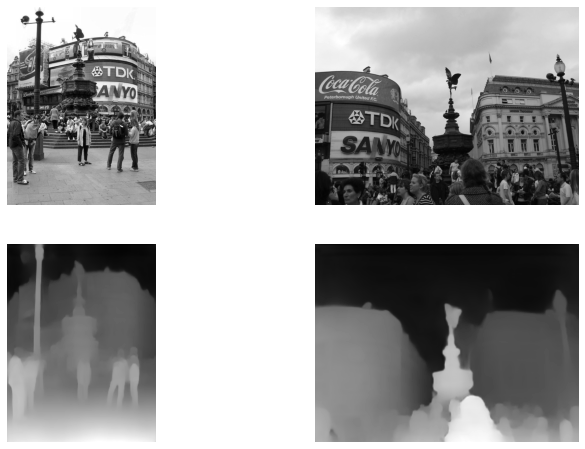

In [5]:
fig, ax = plt.subplots(2,2,figsize=(12,8))

plt.gray()
ax[0,0].imshow(img_left)
ax[0,1].imshow(img_right)
ax[1,0].imshow(depth_left)
ax[1,1].imshow(depth_right)
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

plt.show()

## Extract features and matches

In [6]:
# extract local affine frames (LAFs) from the first image
[feats_l,descs_l] = pyoneacpose.extract_LAFs(img_left,domain_size_pooling=True)

In [7]:
# extract local affine frames from the second image
[feats_r,descs_r] = pyoneacpose.extract_LAFs(img_right,domain_size_pooling=True)

In [8]:
# match LAFs using sift descriptors
[matches, scores] = pyoneacpose.match_LAFs(descs_l, descs_r, True)

In [9]:
lafsd_l = pyoneacpose.augment_LAFs_with_depth(feats_l[matches[:,0]], depth_left)
lafsd_r = pyoneacpose.augment_LAFs_with_depth(feats_r[matches[:,1]], depth_right)

## Perform robust matching usign 1AC+D and GCRANSAC

In [10]:
t=time()
[E,inliers] = pyoneacpose.estimatePose_1ACD_GCRANSAC(lafsd_l, lafsd_r, 
                                                     K_l, K_r, 
                                                     np.uint32(np.asarray(img_left.shape)),
                                                     np.uint32(np.asarray(img_right.shape)),
                                                     cell_number_in_neighborhood_graph=8,
                                                     fps=-1,
                                                     spatial_coherence_weight=0.975,
                                                     confidence=0.99,
                                                     inlier_outlier_threshold=3.00)
print ('GCRANSAC finished in {} seconds.'.format(time()-t))

GCRANSAC finished in 0.0019941329956054688 seconds.


In [11]:
print('Number of matches: {}'.format(matches.shape[0]))
print('Number of inliers: {}'.format(np.sum(inliers)))
print('Inlier ratio: {}%'.format(np.sum(inliers) / matches.shape[0] * 100))

Number of matches: 68
Number of inliers: 38
Inlier ratio: 55.88235294117647%


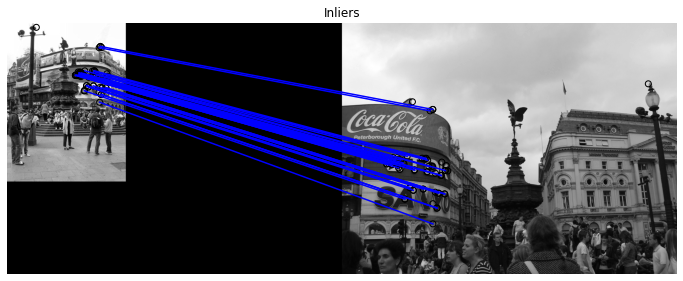

In [12]:
# shor result
src = lafsd_l[:,[1,0]]
dst = lafsd_r[:,[1,0]]

# plot:

fig, ax = plt.subplots(figsize=(12,8))

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax, img_left, img_right, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax.axis('off')
ax.set_title('Inliers')

plt.show()